100%|██████████| 9.91M/9.91M [00:01<00:00, 6.05MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.57MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.59MB/s]


VAE Eğitimi Başlıyor...
Epoch: 1, Ortalama Kayıp: 147.1629
Epoch: 2, Ortalama Kayıp: 115.9607
Epoch: 3, Ortalama Kayıp: 111.4351
Epoch: 4, Ortalama Kayıp: 109.3995
Epoch: 5, Ortalama Kayıp: 108.1786
Epoch: 6, Ortalama Kayıp: 107.3664
Epoch: 7, Ortalama Kayıp: 106.7150
Epoch: 8, Ortalama Kayıp: 106.2291
Epoch: 9, Ortalama Kayıp: 105.8331
Epoch: 10, Ortalama Kayıp: 105.4750
Epoch: 11, Ortalama Kayıp: 105.1889
Epoch: 12, Ortalama Kayıp: 104.9257
Epoch: 13, Ortalama Kayıp: 104.7487
Epoch: 14, Ortalama Kayıp: 104.5698
Epoch: 15, Ortalama Kayıp: 104.3910
Epoch: 16, Ortalama Kayıp: 104.2505
Epoch: 17, Ortalama Kayıp: 104.0620
Epoch: 18, Ortalama Kayıp: 103.9583
Epoch: 19, Ortalama Kayıp: 103.8097
Epoch: 20, Ortalama Kayıp: 103.6817

Yeni Rakamlar Üretiliyor...


/tmp/ipykernel_48/2712186600.py:122: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(8, 8, i+1)


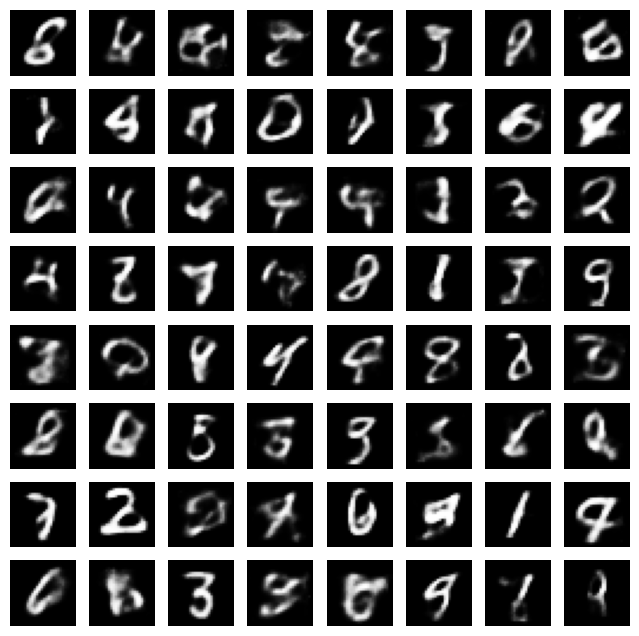

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Ayarlar ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
NUM_EPOCHS = 20
LATENT_DIM = 20  # Gizli alan boyutu (Z vektörü)

# --- 2. Veri Hazırlığı ---
# VAE'de genellikle Binary Cross Entropy kullanıldığı için veriyi 0-1 arasına sıkıştırmak önemlidir.
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# --- 3. VAE Modeli ---
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        # --- ENCODER ---
        self.fc1 = nn.Linear(784, 400)
        self.relu = nn.ReLU()
        
        # Encoder çıktı olarak iki farklı vektör üretir:
        self.fc_mu = nn.Linear(400, LATENT_DIM)      # Ortalama (Mean)
        self.fc_logvar = nn.Linear(400, LATENT_DIM)  # Log Varyans
        
        # --- DECODER ---
        self.fc3 = nn.Linear(LATENT_DIM, 400)
        self.fc4 = nn.Linear(400, 784)
        self.sigmoid = nn.Sigmoid() # Çıktıyı 0-1 arasına getirmek için

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar):
        """
        Rastgelelik katan sihirli adım.
        Eğitim sırasında geri yayılım (backprop) yapabilmek için bu hileyi kullanırız.
        z = mu + std * epsilon
        """
        std = torch.exp(0.5 * logvar) # Log varyansı standart sapmaya çevir
        eps = torch.randn_like(std)   # Standart normal dağılımdan rastgele gürültü (epsilon)
        return mu + eps * std

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x):
        x = x.view(-1, 784)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar) # Örnekleme yap
        return self.decode(z), mu, logvar

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# --- 4. Kayıp Fonksiyonu (Loss Function) ---
def loss_function(recon_x, x, mu, logvar):
    # 1. Yeniden Yapılandırma Kaybı (Görüntü ne kadar benziyor?)
    # Binary Cross Entropy (BCE) pikseller arası fark için iyidir
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # 2. KL Divergence (Dağılım ne kadar düzgün?)
    # Modelin öğrendiği dağılımı Standart Normal Dağılıma (N(0, 1)) zorlar.
    # Bu formül kapalı formda çözülmüştür:
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

# --- 5. Eğitim Döngüsü ---
print("VAE Eğitimi Başlıyor...")
model.train()
for epoch in range(NUM_EPOCHS):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, logvar = model(data)
        
        loss = loss_function(recon_batch, data, mu, logvar)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
    print(f'Epoch: {epoch+1}, Ortalama Kayıp: {train_loss / len(train_loader.dataset):.4f}')

# --- 6. YENİ GÖRÜNTÜ ÜRETİMİ (Generation) ---
print("\nYeni Rakamlar Üretiliyor...")

model.eval()
with torch.no_grad():
    # Rastgele Gürültü Üret (Latent Space'den örnekle)
    # Standart Normal Dağılımdan (N(0, 1)) 64 tane vektör çekiyoruz.
    z = torch.randn(64, LATENT_DIM).to(device)
    
    # Sadece Decoder'ı kullanarak görüntüyü oluştur
    generated_imgs = model.decode(z).cpu()

    # Görselleştirme
    plt.figure(figsize=(8, 8))
    plt.title("VAE Tarafından Üretilen Yeni Rakamlar")
    
    # 8x8'lik bir ızgara oluştur
    grid_img = generated_imgs.view(64, 1, 28, 28)
    
    # Yan yana dizmek için basit bir döngü yerine torchvision.utils.make_grid de kullanılabilir
    # Burada manuel subplot ile gösterelim:
    for i in range(64):
        plt.subplot(8, 8, i+1)
        plt.imshow(generated_imgs[i].view(28, 28), cmap='gray')
        plt.axis('off')
        
    plt.show()